In [1]:
import sys
import os

# Add the parent directory of 'station_focus' to sys.path
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Parent directory
sys.path.append(base_path)
file_path = os.path.join(base_path, "data/boston/bike_trip_focused_data.parquet")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src import data_processing as dp
from sklearn.ensemble import IsolationForest
from src import utils
import geopandas as gpd
from sklearn.metrics import f1_score
import DIFFI.interpretability_module as interp
from DIFFI.utils import *
from matplotlib.ticker import FuncFormatter

from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans


In [2]:
station_data = dp.from_trip_to_station_focused(file_path)

In [3]:
features = [
    'count',                 # Core usage metric
    'distance_mean',         # Average trip distance
    'tripduration_mean',     # Average trip duration
    'speed_mean',            # Average trip speed
    'temp_mean',             # Weather impact
    'prcp_mean',             # Weather impact
    'wspd_mean',             # Weather impact
    'hour',                  # Temporal variation
    'dayofweek',             # Temporal variation
    'nearby_transit_stops'   # Station context
]
X = station_data[features].fillna(0)


In [4]:
sorted_idx = diffi_ranks(X, n_trees=100, max_samples=1024, n_iter=5)

In [5]:
X.columns[sorted_idx]

Index(['tripduration_mean', 'prcp_mean', 'count', 'distance_mean', 'wspd_mean',
       'temp_mean', 'speed_mean', 'hour', 'dayofweek', 'nearby_transit_stops'],
      dtype='object')

# Train IF

In [6]:
n_iter = 30
n_feats_max = X.shape[1]  
out_dict = {}
stability_dict = {}
kmeans_dict = {}

for n_feats in range(1, n_feats_max + 1):
    X_sel_feats = X.iloc[:, sorted_idx[:n_feats]]
    outlier_score_all = []
    stability_all = []
    kmeans_score_all = []

    for j in range(n_iter):
        iso_forest = IsolationForest(n_estimators=100, max_samples=1024, contamination='auto', random_state=j)
        iso_forest.fit(X_sel_feats)

        outlier_score = iso_forest.decision_function(X_sel_feats)
        outlier_score_all.append(outlier_score)

        preds = iso_forest.predict(X_sel_feats)
        stability_all.append(preds)

        kmeans = KMeans(n_clusters=2, random_state=j)
        clusters = kmeans.fit_predict(X_sel_feats)
        kmeans_score = kmeans.inertia_  # Using inertia as an overall measure of clustering
        kmeans_score_all.append(kmeans_score)

    out_dict[n_feats] = np.median(outlier_score_all)

    stability_all = np.array(stability_all)
    stability_dict[n_feats] = np.mean(np.var(stability_all, axis=0))  # Lower variance -> more stable predictions

    kmeans_dict[n_feats] = np.median(kmeans_score_all)


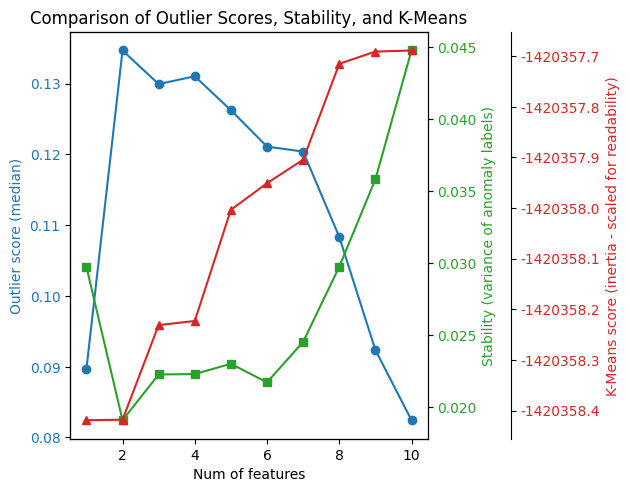

In [7]:
# Function and constant for readability of K-Means plot
large_constant = 1.4271e13

def kmeans_format(x, pos):
    return f'{(x - large_constant) / 1e7:.1f}' 

fig, ax1 = plt.subplots()

ax1.set_xlabel('Num of features')
ax1.set_ylabel('Outlier score (median)', color='tab:blue')
ax1.plot(list(out_dict.keys()), list(out_dict.values()), '-o', color='tab:blue', label='Outlier Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stability (variance of anomaly labels)', color='tab:green')  
ax2.plot(list(stability_dict.keys()), list(stability_dict.values()), '-s', color='tab:green', label='Stability')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax3 = ax1.twinx()  
ax3.spines["right"].set_position(("outward", 60)) 
ax3.set_ylabel(f'K-Means score (inertia - scaled for readability)', color='tab:red')  
ax3.plot(list(kmeans_dict.keys()), list(kmeans_dict.values()), '-^', color='tab:red', label='K-Means')
ax3.tick_params(axis='y', labelcolor='tab:red')

ax3.yaxis.set_major_formatter(FuncFormatter(kmeans_format))

fig.tight_layout()  
plt.title('Comparison of Outlier Scores, Stability, and K-Means')
plt.show()
